# Prediction the cost of cars

## Project description

The service for the sale of used cars is developing an application to attract new customers. It allows you to quickly find out the market value of your car. Historical data is at your disposal: technical specifications, complete sets and prices of cars. You need to build a model to determine the cost.

Important to the customer:
- prediction quality;
- prediction speed;
- training time.

The purpose of the project: to build a model for predicting the cost of cars in accordance with the criteria of the customer.

## Project plan:

1. Prepare the data. Handle anomalies, remove uninformative and low-quality data, handle missing values, get rid of duplicates.
2. Train models `LinearRegression`, `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor`. Find optimal parameters for them.
3. Analyze models and recommend the best for customer's criteria.

## Data description
__Features__:
- _DateCrawled_ — date of downloading the questionnaire from the database
- _VehicleType_ — type of car body
- _RegistrationYear_ — the year of registration of the car
- _Gearbox_ — type of gearbox
- _Power_ — power (hp)
- _Model_ — car model
- _Kilometer_ — mileage (km)
- _RegistrationMonth_ — month of car registration
- _FuelType_ — fuel type
- _Brand_ — car brand
- _Repaired_ — was the car under repair or not
- _DateCreated_ — date of creation of the questionnaire
- _NumberOfPictures_ — the number of photos of the car
- _PostalCode_ — postal code of the questionnaire owner (user)
- _LastSeen_ — the date of the user's last activity

__Target feature__:
- _Price_ — price (euro)

## Loading and preparing data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import time

In [3]:
df = pd.read_csv('/datasets/autos.csv')

display(df.head())
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Not useful features for building a car price prediction model:

- _RegistrationMonth_ — the month of registration of the car;
- _DateCrawled_ — date the questionnaire was downloaded from the database;
- _lastSeen_ — the date of the user's last activity;
- _PostalCode_ — postal code of the questionnaire owner;
- _NumberOfPictures_ — number of photos of the car;
- _DateCreated_ — the date the questionnaire was created.

Remove them:

In [4]:
df = df.drop(columns=['RegistrationMonth', 'DateCrawled', 'LastSeen', 'PostalCode', 'NumberOfPictures', 'DateCreated'])

Data overview to find problems, anomalies:

In [5]:
ProfileReport(df)

There are duplicates, missing values, extremely small or large values in data. How to handle them in different columns:

`Price` column:
- 3% of zeros - remove objects;
- Incredibly small values - remove objects with a price less than 200 euros.

`Power` column (power, hp):
- 11.4% of zeros - remove objects;
- Improbably large and small values - remove objects.

`Model` column (car model):
- 5.6% of the missing values replace with `unknown`.

`RegistrationYear` column (year of registration of the car):
- Incredibly, impossible large and small values - remove objects.

`FuelType` column (fuel type):
- 9.3% of missing values - replace with `unknown`;
- "Petrol" and "gasoline" mean the same thing - replace "gasoline" with "petrol".

`Repaired` column (was the car under repair or not):
- 20.1% of the missing values replace with `unknown`.

`VehicleType` column (car body type):
- 10.6% of the missing values replace with `unknown`.

`Gearbox` column (gearbox type):
- 5.6% of the missing values replace with `unknown`.

Duplicate lines should be removed.

In [6]:
df = df[
    (df['Price']>200)&
    (df['Power']>50)&
    (df['Power']<1800)&
    (df['RegistrationYear']>1980)&
    (df['RegistrationYear']<2017)
]

df[['Model', 'FuelType', 'Repaired', 'VehicleType', 'Gearbox']] = df[['Model', 'FuelType', 'Repaired', 'VehicleType', 'Gearbox']].fillna(value='unknown')

df['FuelType'] = df['FuelType'].str.replace('gasoline', 'petrol')

df = df.drop_duplicates(ignore_index=True)

The abnormal values were removed. The missing values were replaced. Split the data into training, validation, and test samples in the ratio 60:20:20:

In [7]:
def split_set(df):
    features_train, features_valid_test, target_train, target_valid_test = train_test_split(
        df.drop('Price', axis=1), df.Price, test_size=0.4, random_state=12345)

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid_test, target_valid_test, test_size=0.5, random_state=12345)
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

features_train, target_train, features_valid, target_valid, features_test, target_test = split_set(df)

cat_cols = list(features_train.select_dtypes(include=['object']).columns)
num_cols = list(features_train._get_numeric_data().columns)

Data prepared.

## Model training

We will try models `LinearRegression`, `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor`.

Helper functions:

In [30]:
def get_model_params(model, featuret_train, target_train, features_valid, target_valid):
    start = time.time()
    model.fit(featuret_train, target_train)
    time_fit = time.time() - start

    start = time.time()
    predictions = model.predict(features_valid)
    time_predict = time.time() - start
    
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    
    return time_fit, time_predict, rmse

def display_model_params(model_name, time_fit, time_predict, rmse):
    data = {
        "rmse": rmse,
        "time fit": time_fit,
        "time predict": time_predict
    }

    models_analys = pd.DataFrame(data=data, index=[model_name])
    display(models_analys)

Different encoders works better for different models. `OneHotEncoder` for regressions, `OrdinalEncoder` for random forest, internal encoders for gradient boosting.

Create column transformers to encode categorical columns and scale numerical columns:

In [9]:
col_trans_ohe = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scaler', StandardScaler(), num_cols)
])

col_trans_oe = ColumnTransformer(transformers=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('scaler', StandardScaler(), num_cols)
])

### LinearRegression

In [10]:
pipeline_lr = Pipeline(steps=[
    ('col_trans', col_trans_ohe),
    ('model', LinearRegression())
])

pipeline_lr.fit(features_train, target_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('scaler', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer'])])),
                ('model', LinearRegression())])

In [11]:
time_fit_lr, time_predict_lr, rmse_lr = get_model_params(pipeline_lr, features_train, target_train, features_valid, target_valid)
display_model_params('LinearRegression', time_fit_lr, time_predict_lr, rmse_lr)

,rmse,time fit,time predict
LinearRegression,2563.239676,1.892919,0.088018


High value of RMSE. Let's try the methods of regularization of linear regression: Lasso and Ridge.

### Lasso

In [12]:
params_lasso = {'model__alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5]}

pipeline_lasso = Pipeline(steps=[
    ('col_trans', col_trans_ohe),
    ('model', Lasso(random_state=12345))
])

grid_pipeline_lasso = GridSearchCV(pipeline_lasso, params_lasso, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_pipeline_lasso.fit(features_train, target_train)
best_lasso = grid_pipeline_lasso.best_estimator_

C:\Users\Maria\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251752257518.9325, tolerance: 316469265.19587904
  model = cd_fast.sparse_enet_coordinate_descent(


In [13]:
time_fit_lasso, time_predict_lasso, rmse_lasso = get_model_params(best_lasso, features_train, target_train, features_valid, target_valid)
display_model_params('Lasso', time_fit_lasso, time_predict_lasso, rmse_lasso)

C:\Users\Maria\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251752257518.9325, tolerance: 316469265.19587904
  model = cd_fast.sparse_enet_coordinate_descent(


,rmse,time fit,time predict
Lasso,2563.298641,98.892271,0.084019


### Ridge

In [14]:
params_ridge = {'model__alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5]}

pipeline_ridge = Pipeline(steps=[
    ('col_trans', col_trans_ohe),
    ('model', Ridge(random_state=12345))
])

grid_pipeline_ridge = GridSearchCV(pipeline_ridge, params_ridge, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_pipeline_ridge.fit(features_train, target_train)
best_ridge = grid_pipeline_ridge.best_estimator_

In [15]:
time_fit_ridge, time_predict_ridge, rmse_ridge = get_model_params(best_ridge, features_train, target_train, features_valid, target_valid)
display_model_params('Ridge', time_fit_ridge, time_predict_ridge, rmse_ridge)

,rmse,time fit,time predict
Ridge,2563.56468,0.810986,0.096022


Lasso and Ridge did not give better results compared to linear regression without regularization.

### RandomForestRegressor

In [16]:
params_rf = {'model__n_estimators': [100, 300, 500]}

pipeline_rf = Pipeline(steps=[
    ('col_trans', col_trans_oe),
    ('model', RandomForestRegressor(n_jobs=-1, random_state=12345))
])

grid_pipeline_rf = GridSearchCV(pipeline_rf, params_rf)
grid_pipeline_rf.fit(features_train, target_train)
best_rf = grid_pipeline_rf.best_estimator_

In [17]:
time_fit_rf, time_predict_rf, rmse_rf = get_model_params(best_rf, features_train, target_train, features_valid, target_valid)
display_model_params('RandomForestRegressor', time_fit_rf, time_predict_rf, rmse_rf)

,rmse,time fit,time predict
RandomForestRegressor,1679.450033,28.775242,1.377692


### CatBoostRegressor

In [18]:
params_cb = {'depth': [6,8,10],
             'learning_rate' : [0.01, 0.05, 0.1],
             'iterations' : [30, 50, 100]
            }

grid_cb = GridSearchCV(estimator=CatBoostRegressor(loss_function="RMSE", cat_features=cat_cols, silent=True, random_state=12345), param_grid = params_cb)
grid_cb.fit(features_train, target_train)
best_cb = grid_cb.best_estimator_

In [19]:
time_fit_cb, time_predict_cb, rmse_cb = get_model_params(best_cb, features_train, target_train, features_valid, target_valid)
display_model_params('CatBoostRegressor', time_fit_cb, time_predict_cb, rmse_cb)

,rmse,time fit,time predict
CatBoostRegressor,1689.863618,10.257618,0.10099


### LGBMRegressor

In [20]:
def convert_dtype(type_before, type_after, df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == type_before:
            df[c] = df[c].astype(type_after)
    return df

df_conv = convert_dtype("object", "category", df)
features_train_conv, target_train_conv, features_valid_conv, target_valid_conv, features_test_conv, target_test_conv = split_set(df_conv)

In [21]:
params_lgbm = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500]
}

grid_lgbm = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=12345), param_grid = params_lgbm, n_jobs=-1, verbose=False)
grid_lgbm.fit(features_train_conv, target_train_conv)
best_lgbm = grid_lgbm.best_estimator_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 145840, number of used features: 9
[LightGBM] [Info] Start training from score 5093.990483


In [22]:
time_fit_lgbm, time_predict_lgbm, rmse_lgbm = get_model_params(best_lgbm, features_train_conv, target_train_conv, features_valid_conv, target_valid_conv)
display_model_params('LGBMRegressor', time_fit_lgbm, time_predict_lgbm, rmse_lgbm)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 145840, number of used features: 9
[LightGBM] [Info] Start training from score 5093.990483


,rmse,time fit,time predict
LGBMRegressor,1563.299125,1.675272,0.321655


## Model analysis

Let's compare the RMSE quality metric, training time and prediction time:

In [23]:
data = {
    "RMSE": [rmse_lr, rmse_lasso, rmse_ridge, rmse_rf, rmse_cb, rmse_lgbm],
    "time_fit": [time_fit_lr, time_fit_lasso, time_fit_ridge, time_fit_rf, time_fit_cb, time_fit_lgbm],
    "time_predict": [time_predict_lr, time_predict_lasso, time_predict_ridge, time_predict_rf, time_predict_cb, time_predict_lgbm]
}

models_analys = pd.DataFrame(data=data, index=["LinearRegression", "Lasso", "Ridge", "RandomForest", "CatBoost", "LGBMRegressor"])
display(models_analys)

,RMSE,time_fit,time_predict
LinearRegression,2563.239676,1.892919,0.088018
Lasso,2563.298641,98.892271,0.084019
Ridge,2563.564680,0.810986,0.096022
RandomForest,1679.450033,28.775242,1.377692
CatBoost,1689.863618,10.257618,0.100990
LGBMRegressor,1563.299125,1.675272,0.321655


The `LGBMRegressor` model has the best combination of customer's criteria (RMSE metric, training time and prediction time). I recommend this model to customer. Let's check its quality on a test sample:

In [26]:
features_union_train_valid_conv = pd.concat([features_train_conv, features_valid_conv])
target_union_train_valid_conv = pd.concat([target_train_conv, target_valid_conv])

time_fit_lgbm_test, time_predict_lgbm_test, rmse_lgbm_test = get_model_params(best_lgbm, features_union_train_valid_conv, target_union_train_valid_conv, features_test_conv, target_test_conv)
display_model_params('LGBMRegressor test', time_fit_lgbm_test, time_predict_lgbm_test, rmse_lgbm_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 194453, number of used features: 9
[LightGBM] [Info] Start training from score 5102.093138


,rmse,time fit,time predict
LGBMRegressor test,1534.897844,1.927732,0.300575


There is a good quality on the test data. Let's look at the importance of factors for the model:

<Axes: >

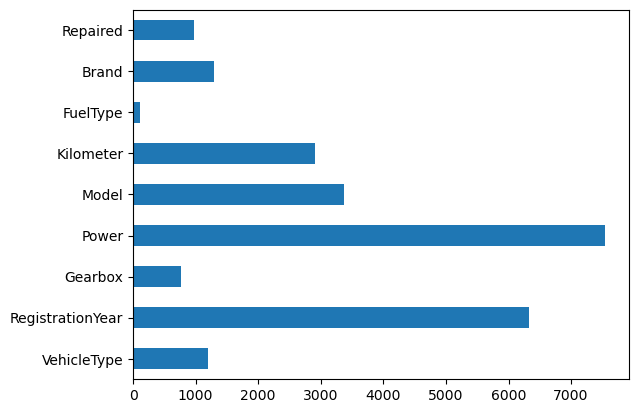

In [29]:
pd.Series(best_lgbm.feature_importances_, index=features_union_train_valid_conv.columns).plot(kind='barh')

The most important factors are `Power` and `RegistrationYear' (year of registration of the car).

## Conclusion

- Preprocessed the data. I found and removed anomalies, filled in missing values. Deleted duplicates and removed unnecessary features.
- I trained several models with the tuning of hyperparameters. Chose the best model for customer's criteria: prediction quality, training time and prediction time.
- The LGBMRegressor model turned out to be the best of all. The value of the RMSE metric = 1535 in the test sample, the training time is 1.93 seconds, the prediction time is 0.3 seconds.